# Categorical prediction for houses in Iowa --> Expensive vs. not expensive

The task: create a model that if a house is "expensive" oder "not expensive" based on its characteristics.  
Basis is a datase with 1460 houses and 79 describing features.  
Explanation of features can be found in the txt file data_description.


This is the 2nd part of the task. The first notebook "preparation_data"  was used to explore the dataframe.  

This notebook creates separate pipes to test several models and store the results. 
The best results are used to create a prediction with a seaparate test dataframe to submit into a students competition

In [57]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, MinMaxScaler, StandardScaler
from sklearn.compose import make_column_transformer, make_column_selector
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.ensemble import RandomForestClassifier
from sklearn import set_config
set_config(transform_output="pandas")
pd.set_option('display.max_rows', 50)

## Import

In [59]:
houses_raw = pd.read_csv("data/housing-classification-iter6.csv")
houses_df = houses_raw.copy().drop_duplicates()
X = houses_df.copy()
X = X.drop(columns=["Id"])
y = y = houses_df.pop("Expensive")
X_train, X_test,y_train, y_test = train_test_split(X,y,test_size = 0.2, random_state = 12120)

## Ordinal Categories

order for ordinal encoding

In [62]:
# define order of categories in each feature for ordinal encoding
ExterQual_ord = ["Po", "Fa", "TA", "Gd", "Ex"]
ExterCond_ord = ["Po", "Fa", "TA", "Gd", "Ex"]
BsmtQual_ord = ["NA","Po", "Fa", "TA", "Gd", "Ex"]
BsmtCond_ord = ["NA","Po", "Fa", "TA", "Gd", "Ex"]
BsmtExposure_ord = ["NA", "No", "Mn", "Av", "Gd"]
BsmtFinType1_ord = ["NA", "unf", "LwQ", "Rec", "BLQ", "ALQ", "GLQ"]
KitchenQual_ord = ["Po", "Fa", "TA", "Gd", "Ex"]
FireplaceQu_ord = ["Po", "Fa", "TA", "Gd", "Ex"]
LotShape_ord = ["IR3","IR2", "IR1","Reg"]
Utilities_ord = ["ELO","NoSeWa","NoSewr","AllPub"]
HeatingQC_ord = ["Po", "Fa", "TA", "Gd", "Ex"]
GarageFinish_ord = ["NA","Unf", "RFn","Fin"]
GarageQual_ord = ["NA","Po", "Fa", "TA", "Gd", "Ex"]
PavedDrive_ord = ["N","P","Y"]
Fence_ord= ["NA", "MnWw","GdWo","MnPrv","GdPrv"]

# dictionary for ordinal encoding
category_order={"ExterQual": ExterQual_ord, 
            "ExterCond": ExterCond_ord,
            "BsmtQual": BsmtQual_ord,
            "BsmtCond": BsmtCond_ord,
            "BsmtExposure": BsmtExposure_ord,
            "BsmtFinType1": BsmtFinType1_ord, 
            "KitchenQual": KitchenQual_ord,
            "FireplaceQu": FireplaceQu_ord,
            "LotShape" : LotShape_ord ,
            "Utilities" : Utilities_ord ,
            "HeatingQC" : HeatingQC_ord ,
            "GarageFinish" : GarageFinish_ord ,
            "GarageQual" : GarageQual_ord ,
            "PavedDrive" : PavedDrive_ord ,
            "Fence" : Fence_ord
               
               }

## Pipeline without scaling

Initialize the pipeline parts

In [65]:

def no_scaling_pipe(model, X_cat, X_num, X_ord):
    """
    Creates a machine learning pipeline for preprocessing and modeling without scaling numerical features.

    Parameters:
    - model: The machine learning model to be used.
    - X_cat: The categorical features of the dataset.
    - X_num: The numerical features of the dataset.
    - X_ord: The ordinal features of the dataset.

    Returns:
    - no_scale_pipe: The machine learning pipeline without scaling numerical features.
    """

    # Create encoders for categorical and ordinal features
    hot = OneHotEncoder(sparse_output=False, drop="first", handle_unknown="ignore")
    ordinal = OrdinalEncoder(categories=[category_order[feature] for feature in category_order],
                             handle_unknown = "use_encoded_value",
                             unknown_value = -1)

    # Create pipelines for numerical, categorical, and ordinal features
    num_pipe = make_pipeline(SimpleImputer())
    cat_pipe = make_pipeline(SimpleImputer(strategy="constant", fill_value="unknown"), hot)
    ord_pipe = make_pipeline(SimpleImputer(strategy="constant",fill_value="unknown"), ordinal)

    # Create a column transformer to apply the pipelines to the respective features
    preprocessor = make_column_transformer(
        (num_pipe, X_num),
        (cat_pipe, X_cat),
        (ord_pipe, X_ord)
    )

    # Create the final pipeline by combining the preprocessor and the model
    no_scale_pipe = make_pipeline(preprocessor, model)

    return no_scale_pipe

## Pipeline with scaling

In [67]:
def scaling_pipe(scaled_model, X_cat, X_num, X_ord, scaler):
    """
    Creates a machine learning pipeline for preprocessing and modeling with scaling numerical features.

    Parameters:
    - scaled_model: The scaled machine learning model to be used.
    - X_cat: The categorical features of the dataset.
    - X_num: The numerical features of the dataset.
    - X_ord: The ordinal features of the dataset.
    - scaler: The scaler to be applied to the numerical, categorical, and ordinal features.

    Returns:
    - scaled_pipe: The machine learning pipeline with scaling numerical features.

    """

    # Create encoders for categorical and ordinal features
    hot = OneHotEncoder(sparse_output=False, drop="first", handle_unknown="ignore")
    ordinal = OrdinalEncoder(categories=[category_order[feature] for feature in category_order],
                                handle_unknown = "use_encoded_value",
                                 unknown_value = -1)

    # Create pipelines for numerical, categorical, and ordinal features with the scaler
    num_pipe = make_pipeline(SimpleImputer(), scaler)
    cat_pipe = make_pipeline(SimpleImputer(strategy="constant", fill_value="unknown"), hot, scaler)
    ord_pipe = make_pipeline(SimpleImputer(strategy="constant",fill_value="unknown"), ordinal, scaler)

    # Create a column transformer to apply the pipelines to the respective features
    preprocessor = make_column_transformer(
        (num_pipe, X_num),
        (cat_pipe, X_cat),
        (ord_pipe, X_ord)
    )

    # Create the final pipeline by combining the preprocessor and the scaled model
    scaled_pipe = make_pipeline(preprocessor, scaled_model)

    return scaled_pipe

In [68]:
X_ord = X_train.loc[:,(["ExterQual","ExterCond","BsmtQual","BsmtCond","BsmtExposure", "BsmtFinType1","KitchenQual",
"FireplaceQu","LotShape","Utilities" , "HeatingQC","GarageFinish" , "GarageQual", "PavedDrive" ,"Fence",])].columns

X_num = X_train.select_dtypes(include="number").columns

X_cat = X_train.loc[:,["MSZoning" ,"Condition1" ,"CentralAir" ,"Foundation" ,"LandContour" ,"LotConfig"  ,   
"LandSlope" ,"Neighborhood", "Condition2","BldgType","HouseStyle" ,"RoofStyle" ,"Exterior1st"  ,  
"Exterior2nd","MasVnrType" ,"Electrical" ,"GarageType" ,"GarageFinish" ,"MiscFeature"   ,
"SaleType","SaleCondition" ]].columns


In [69]:

# Model without scaling in no_scale pipe
model = RandomForestClassifier(n_estimators=100, random_state = 12120)
full_pipe = no_scaling_pipe(model, X_cat,X_num,X_ord)

# Model with scaling in scaled pipe
scaled_model = KNeighborsClassifier()
scaler = MinMaxScaler()

full_pipe_scaled = scaling_pipe(scaled_model, X_cat,X_num,X_ord,scaler)

In [70]:
full_pipe_scaled

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('pipeline-1',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer()),
                                                                  ('minmaxscaler',
                                                                   MinMaxScaler())]),
                                                  Index(['LotArea', 'LotFrontage', 'TotalBsmtSF', 'BedroomAbvGr', 'Fireplaces',
       'PoolArea', 'GarageCars', 'WoodDeckSF', 'ScreenPorch', 'Expensive',
       'MSSubClass', 'OverallQual', 'OverallCond', 'YearB...
                                                                                  handle_unknown='use_encoded_value',
                                                                                  unknown_value=-1)),
                                                                  ('minmaxscaler',
                                                                   MinMaxScaler())]),
                                                  Index(['ExterQual', 'ExterCond', 'BsmtQual', 'BsmtCond', 'BsmtExposure',
       'BsmtFinType1', 'KitchenQual', 'FireplaceQu', 'LotShape', 'Utilities',
       'HeatingQC', 'GarageFinish', 'GarageQual', 'PavedDrive', 'Fence'],
      dtype='object'))])),
                ('kneighborsclassifier', KNeighborsClassifier())])

## Parameter fitting with GridSearch

In [72]:
# define parameters for tested Models

# Parameter for KNeighbors 
parameter_knn = {"columntransformer__pipeline-1__simpleimputer__strategy":["mean","median","most_frequent"],
                    "columntransformer__pipeline-2__onehotencoder__min_frequency":range(10,20,2),
                    "kneighborsclassifier__n_neighbors":range(12,20),
                    "kneighborsclassifier__weights": ["uniform","distance"],
                     "kneighborsclassifier__p": [1]

                 } 
#Parameter for Decision Tree Classifier
parameter_tree = {"columntransformer__pipeline-1__simpleimputer__strategy":["mean","median","most_frequent"],
                    "columntransformer__pipeline-2__onehotencoder__min_frequency": range(3,9,3),
                    "decisiontreeclassifier__criterion":["log_loss","gini"],
                    "decisiontreeclassifier__max_depth": range(8,28,3),
                    #"decisiontreeclassifier__min_samples_leaf": range(5,10),
                    "decisiontreeclassifier__max_features": range(5,58,5),
                    #"decisiontreeclassifier__min_impurity_decrease": [0.0, 0.005]

                }
#Parameter for Random Forest Classifier
parameter_forest = {"columntransformer__pipeline-1__simpleimputer__strategy":["mean","median","most_frequent"],
                    "columntransformer__pipeline-2__onehotencoder__min_frequency": [3],
                    "randomforestclassifier__criterion":["log_loss"],
                    "randomforestclassifier__max_depth": range(6,12,2),
                    "randomforestclassifier__min_samples_split": range(5,30,5),
                    "randomforestclassifier__max_features": ["sqrt","None"],
                    "randomforestclassifier__min_impurity_decrease": [0.0, 0.005]
                 } 

In [73]:
# stores results of the grid search parameter

results_dict = {}
nr = 0

In [74]:
# Grid Search function using the set parameter and 5 folds on accuracy score

def grid_search(pipe,parameters,folds, X_train,y_train):

    grid_search = GridSearchCV( pipe,
                            parameters,
                            cv = 5,
                            scoring = "accuracy",
                            verbose = 1
                          )
    return grid_search.fit(X_train,y_train)

In [ ]:
# execute grid search function with several models and store the results in result dictionary
grid_search = grid_search(full_pipe,parameter_forest,5,X_train,y_train)
nr = nr+1
results_dict.update({f"Score_run_{nr}": grid_search.best_score_})
results_dict.update({f"param_run_{nr}": grid_search.best_params_})
results_dict.update({f"param_run_{nr}": confusion_matrix(y_true = y_train, y_pred = search_fin.predict(X_train))} )

In [83]:
results_dict

{'Score_run_1': 0.9897215802795202,
 'param_run_1': {'columntransformer__pipeline-1__simpleimputer__strategy': 'most_frequent',
  'columntransformer__pipeline-2__onehotencoder__min_frequency': 3,
  'randomforestclassifier__criterion': 'log_loss',
  'randomforestclassifier__max_depth': 10,
  'randomforestclassifier__max_features': 'sqrt',
  'randomforestclassifier__min_impurity_decrease': 0.0,
  'randomforestclassifier__min_samples_split': 5}}

## results controlling with best scores

the best results from testing are used to predict the test data and the submission test data

In [87]:
# define final Parameters of best model Random Forest

parameter_final =  {"columntransformer__pipeline-1__simpleimputer__strategy":["median"],
                    "columntransformer__pipeline-2__onehotencoder__min_frequency": [3],
                    "randomforestclassifier__criterion":["log_loss"],
                    "randomforestclassifier__max_depth": [10],
                    'randomforestclassifier__max_features': ["sqrt"],
                    'randomforestclassifier__min_samples_split': [15]}

In [89]:
#final grid search for Random Forest with 5 folds and score accuracy
search_final  = GridSearchCV( full_pipe,
                            parameter_final,
                            cv = 5,
                            scoring = "accuracy",
                            verbose = 1
                          )

In [ ]:
search_final.fit(X_train,y_train)

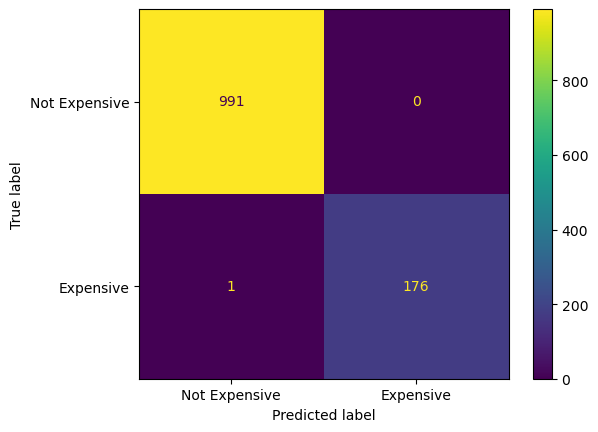

In [93]:
# Plot Confusion Matrix to show results from final fit
ConfusionMatrixDisplay.from_estimator(search_final,
                                      X_train,
                                      y_train,
                                      display_labels=['Not Expensive', 'Expensive']);

**Test Data**

In [95]:
# Predict and calculate accuracy on test data
accuracy_score(search_final.predict(X_test),y_test)

C:\Users\hanne\anaconda3\Lib\site-packages\sklearn\preprocessing\_encoders.py:227: UserWarning: Found unknown categories in columns [8] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


0.9863013698630136

In [97]:
# Concat Train and Test Data for full set
X = pd.concat([X_train,X_test])
y = pd.concat([y_train,y_test])
#Fit final model to full data 
search_final.best_estimator_.fit(X,y)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('pipeline-1',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='median'))]),
                                                  Index(['LotArea', 'LotFrontage', 'TotalBsmtSF', 'BedroomAbvGr', 'Fireplaces',
       'PoolArea', 'GarageCars', 'WoodDeckSF', 'ScreenPorch', 'Expensive',
       'MSSubClass', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemo...
                                                                                  unknown_value=-1))]),
                                                  Index(['ExterQual', 'ExterCond', 'BsmtQual', 'BsmtCond', 'BsmtExposure',
       'BsmtFinType1', 'KitchenQual', 'FireplaceQu', 'LotShape', 'Utilities',
       'HeatingQC', 'GarageFinish', 'GarageQual', 'PavedDrive', 'Fence'],
      dtype='object'))])),
                ('randomforestclassifier',
                 RandomForestClassifier(criterion='log_loss', max_depth=10,
                                        min_samples_split=15,
                                        random_state=12120))])

In [111]:
# Read submission test data 
new_data = pd.read_csv("data/test.csv")

In [113]:
# delete ID column
id_col = new_data.pop('Id')
new_data

,LotArea,LotFrontage,TotalBsmtSF,BedroomAbvGr,Fireplaces,PoolArea,GarageCars,WoodDeckSF,ScreenPorch,MSZoning,...,GarageType,GarageFinish,GarageQual,GarageCond,PavedDrive,PoolQC,Fence,MiscFeature,SaleType,SaleCondition
0,11622,80.0,882.0,2,0,0,1.0,140,120,RH,...,Attchd,Unf,TA,TA,Y,NaN,MnPrv,NaN,WD,Normal
1,14267,81.0,1329.0,3,0,0,1.0,393,0,RL,...,Attchd,Unf,TA,TA,Y,NaN,NaN,Gar2,WD,Normal
2,13830,74.0,928.0,3,1,0,2.0,212,0,RL,...,Attchd,Fin,TA,TA,Y,NaN,MnPrv,NaN,WD,Normal
3,9978,78.0,926.0,3,1,0,2.0,360,0,RL,...,Attchd,Fin,TA,TA,Y,NaN,NaN,NaN,WD,Normal
4,5005,43.0,1280.0,2,0,0,2.0,0,144,RL,...,Attchd,RFn,TA,TA,Y,NaN,NaN,NaN,WD,Normal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1454,1936,21.0,546.0,3,0,0,0.0,0,0,RM,...,NaN,NaN,NaN,NaN,Y,NaN,NaN,NaN,WD,Normal
1455,1894,21.0,546.0,3,0,0,1.0,0,0,RM,...,CarPort,Unf,TA,TA,Y,NaN,NaN,NaN,WD,Abnorml
1456,20000,160.0,1224.0,4,1,0,2.0,474,0,RL,...,Detchd,Unf,TA,TA,Y,NaN,NaN,NaN,WD,Abnorml
1457,10441,62.0,912.0,3,0,0,0.0,80,0,RL,...,NaN,NaN,NaN,NaN,Y,NaN,MnPrv,Shed,WD,Normal


In [117]:
# Predict final model on New test data
expensive = search_final.predict(X_test)

In [ ]:
# Create submission
submission_file = pd.DataFrame({
    'Id':id_col,
    'Expensive':expensive
})
submission_file.to_csv('data/submission_marsu.csv',index=False) 